# Machine Learning Assignment 2

- [EDA](#EDA)
- [Classifiers](#Classifiers)
- [Stacking](#Stacking)
- [Predictions](#Predictions)

## Imports


In [1]:
# Need these
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

# For splitting by punctuation and using regex
import re
import string

# Useful
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2

# Potentially used Models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import LinearSVC, SVC

# Evaluation and feature selection tools
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_selection import chi2, mutual_info_classif

#benchmark
from sklearn.dummy import DummyClassifier

from datetime import datetime
from sklearn.model_selection import GridSearchCV
from scipy import sparse

# Files

In [2]:
# read in train and test data

meta_train_df = pd.read_csv("review_meta_train.csv")
text_train_df = pd.read_csv("review_text_train.csv")
train_data = pd.concat([text_train_df, meta_train_df], axis=1)

meta_test_df = pd.read_csv("review_meta_test.csv")
text_test_df = pd.read_csv("review_text_test.csv")
test_data = pd.concat([text_test_df, meta_test_df], axis=1)

In [3]:
train_data.head()

,review,date,review_id,reviewer_id,business_id,vote_funny,vote_cool,vote_useful,rating
0,dear longman & eagle.......you've left me no c...,3/15/2012,-s77HISu8DVQ8F0HxmWW6A,mthr7h15a_z9m9jRI6mG6Q,m5_GCJP2W4zEJnyVgxa3eA,0,1,3,1
1,Delish. The hubby and I wanted to do brunch on...,6/21/2010,A2aCzGCgg6gAbatHiCrPfA,rhM01fl3iU0xHr3TIpCMhQ,m5_GCJP2W4zEJnyVgxa3eA,0,0,0,5
2,"yep, I've giving Yolk 5 stars. It's just reall...",7/29/2011,DK2pd,SNHKDgmGiLn5chUlhdLCkg,CwPi6NVuJIZZx4IBcTekFQ,1,0,1,5
3,"Meat, meat, meat. It's meat-tastic. So much me...",3/10/2006,b3BkUiWJEKNQko,HXjk1RVfLMPeZxitnk1Auw,43rd1LKcZRIunySzbMsyLQ,17,3,3,3
4,I caught up with the law school girls on a Sat...,8/28/2012,RabHhte,W0ny0BqO0OJ4K4aVnSIlBw,CwPi6NVuJIZZx4IBcTekFQ,0,0,0,3


In [4]:
# doc2vec 50, 100, 200 features vector for training
d2v_50_train = pd.read_csv(r"review_text_features_doc2vec50/review_text_train_doc2vec50.csv", index_col = False, delimiter = ",", header=None)
d2v_100_train = pd.read_csv(r"review_text_features_doc2vec100/review_text_train_doc2vec100.csv", index_col = False, delimiter = ",", header=None)
d2v_200_train = pd.read_csv(r"review_text_features_doc2vec200/review_text_train_doc2vec200.csv", index_col = False, delimiter = ",", header=None)

# train_data_d2v_50 = pd.concat([d2v_50_train, meta_train_df], axis=1)
# train_data_d2v_100 = pd.concat([d2v_100_train, meta_train_df], axis=1)
# train_data_d2v_200 = pd.concat([d2v_200_train, meta_train_df], axis=1)

# # doc2vec 50, 100, 200 features vector for testing
# d2v_50_test = pd.read_csv(r"review_text_features_doc2vec50/review_text_test_doc2vec50.csv", index_col = False, delimiter = ",", header=None)
# d2v_100_test = pd.read_csv(r"review_text_features_doc2vec100/review_text_test_doc2vec100.csv", index_col = False, delimiter = ",", header=None)
# d2v_200_test = pd.read_csv(r"review_text_features_doc2vec200/review_text_test_doc2vec200.csv", index_col = False, delimiter = ",", header=None)

## EDA

lets take a quick look at the class labels...

In [5]:
print(train_data['rating'].value_counts())

5    19288
3     6444
1     2336
Name: rating, dtype: int64


Looks like 5 stars is by far the most popular class. Potentially could look to undersample class 5 or oversample classes 1 and 3 when training the data. Otherwise, the learner might get lazy and select the majority class too often. As a benchmark, we can look to outperform the ZeroR classifier.

In [6]:
zeroR = DummyClassifier(strategy = "most_frequent")
zeroR.fit(train_data.rating, train_data.rating)
score = zeroR.score(train_data.rating, train_data.rating)
print("zeroR accuracy is {:.4f}...".format(score))

zeroR accuracy is 0.6872...


exploration of the meta data...

In [7]:
rating_value_counts = train_data.groupby(['reviewer_id'])['rating'].count().reset_index().rating.value_counts()
rating_value_counts = rating_value_counts.reset_index().rename(columns = {"index": "count"})
rating_value_counts

,count,rating
0,1,15777
1,2,2596
2,3,805
3,4,364
4,5,208
5,6,103
6,7,74
7,8,37
8,9,24
9,10,11


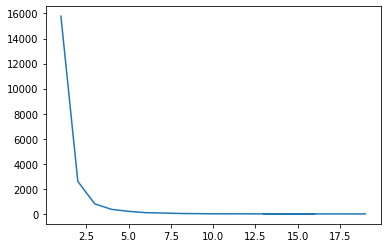

In [8]:
plt.plot(rating_value_counts["count"], rating_value_counts["rating"])

A vast majority of reviewers have either 1 or 2 reviews... However, some reviewers have multiple reviews. This could be a useful feature to detect some edge cases...

In [9]:
# transform the vote counts into percentage votes 

votes = ['vote_funny', 'vote_cool', 'vote_useful']
# votes_df = train_data[['vote_funny', 'vote_cool', 'vote_useful', 'rating']]
train_data['total_votes'] = train_data['vote_funny'] + train_data['vote_cool'] + train_data['vote_useful']

for vote in votes:
    percentage_votes = 'percentage_' + vote
    train_data[percentage_votes] = train_data[vote] / train_data['total_votes']
    
train_data = train_data.fillna(0)

In [10]:
train_data.groupby(['rating']).agg(
    {
        'percentage_vote_funny': ['mean'], 
        'percentage_vote_cool': ['mean'],
        'percentage_vote_useful': ['mean']
    }
)

,percentage_vote_funny,percentage_vote_cool,percentage_vote_useful
,mean,mean,mean
rating,,,
1,0.142341,0.051008,0.289528
3,0.088110,0.088423,0.260617
5,0.075794,0.130812,0.214226


There appears to be directionality between the mean percentage votes and the rating someone is given... Perhaps this could be useful in cases where a machine learning algorithm cannot detect sarcasm by itself. Lets look at some of these funny reviews as an example!

In [11]:
train_data.loc[(train_data.rating == 1) & (train_data.percentage_vote_funny > 0.5)].reset_index().iloc[0].review

"snooze-a-roo. I ordered some breakfast sandwich, and when it showed up, it was just a croissant with two strips of bacon on it and nothing else, so fifteen minutes later when the waitress came back and I complained, she brought me a plate with the other stuff that was supposed to come on it. It cost 12 dollars and the wait is a half hour to be smashed in a corner where there is nowhere to put your winter coat. I can't understand the appeal of this place. I would recommend that folks try anything else for breakfast. Maybe a donkey punch or a dirty sanchez would be more satisfying.\n"

The author is being sarcastic "Maybe a donkey punch or a dirty sanchez would be more satisfying" but you would also expect this review to receive a negative rating...

What about data? are critics getting harsher over time, or is there another trend we are able to detect?

In [12]:
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['year'] = train_data['date'].apply(lambda x: x.year)

In [13]:
train_data.groupby(['year']).agg({'rating': ['mean', 'count']})

rating      
          mean count
year                
2004  5.000000     4
2005  4.580000   100
2006  4.360902   532
2007  4.256887  1561
2008  4.159780  2904
2009  4.197502  4324
2010  4.225112  6499
2011  4.212743  7314
2012  4.174741  4830

Do critics get harsher over time? or perhaps do movies get worse??? or maybe its just due to the small sample size in years 2004 and 2005.

In [14]:
X = train_data.review
y = train_data.rating

In [15]:
vectorizer = CountVectorizer(stop_words = 'english')
vectorizer.fit(X)
X = vectorizer.transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

Lets start by training individual classifiers...

# Classifiers

# Multinomial Naive Bayes
MNB runs ~84% with ngrams (1,1). ~72% with ngrams(1,2), ~69% with ngrams (1,3)

In [23]:
from sklearn.naive_bayes import MultinomialNB

In [24]:
params = {'alpha': [0.1, 1]} 
mnb = MultinomialNB()
mnb_grid = GridSearchCV(mnb, params)
mnb_grid.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None, param_grid={'alpha': [0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
cv_results = pd.DataFrame(mnb_grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014602,7.976272e-04,0.002398,0.000487,0.1,{'alpha': 0.1},0.822943,0.819202,0.824190,0.821308,0.823980,0.822324,0.001865,2
1,0.015000,1.507891e-07,0.002400,0.000490,1,{'alpha': 1},0.832918,0.841646,0.842358,0.836273,0.834135,0.837466,0.003863,1


In [26]:
cv_results.loc[cv_results.rank_test_score == 1].params

1    {'alpha': 1}
Name: params, dtype: object

Lets train the mnb classifier using all the data and these hyperparameters...

In [27]:
mnb = MultinomialNB(alpha = 1)
mnb.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

multinominal naive bayes accuracy: 0.8404


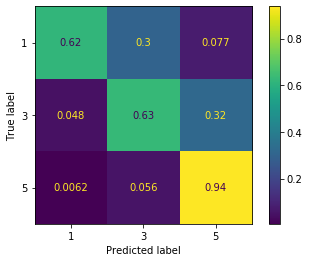

In [28]:
predictions = mnb.predict(X_test)
score = mnb.score(X_test, y_test)
print("multinominal naive bayes accuracy: {:.4f}".format(score))
plot_confusion_matrix(mnb, X_test, y_test, normalize = "true")

# Logistic Regression

In [97]:
from sklearn.linear_model import LogisticRegression

In [102]:
params = {
    'penalty': ['l2'],
    'C': [0.01, 0.1 , 1, 10],
    'max_iter': [1000000]
} 
logreg = LogisticRegression()
logreg_grid = GridSearchCV(logreg, params)
logreg_grid.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [1000000],
                         'penalty': ['l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [103]:
cv_results = pd.DataFrame(logreg_grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.349636,0.107284,0.002800,0.00040,0.01,1000000,l2,"{'C': 0.01, 'max_iter': 1000000, 'penalty': 'l2'}",0.826327,0.834165,0.830602,0.826831,0.838055,0.831196,0.004449,3
1,3.031108,0.105894,0.002799,0.00040,0.1,1000000,l2,"{'C': 0.1, 'max_iter': 1000000, 'penalty': 'l2'}",0.840933,0.846633,0.846455,0.848210,0.851595,0.846765,0.003451,1
2,6.181928,0.080295,0.002800,0.00040,1,1000000,l2,"{'C': 1, 'max_iter': 1000000, 'penalty': 'l2'}",0.830602,0.840221,0.836124,0.837342,0.844468,0.837751,0.004586,2
3,10.630829,0.424733,0.002400,0.00049,10,1000000,l2,"{'C': 10, 'max_iter': 1000000, 'penalty': 'l2'}",0.816352,0.821696,0.818133,0.822020,0.828078,0.821256,0.004028,4


In [104]:
cv_results.loc[cv_results.rank_test_score == 1].params

1    {'C': 0.1, 'max_iter': 1000000, 'penalty': 'l2'}
Name: params, dtype: object

Lets train the mnb classifier using all the data and these hyperparameters...

In [105]:
logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

multinominal naive bayes accuracy: 0.8463


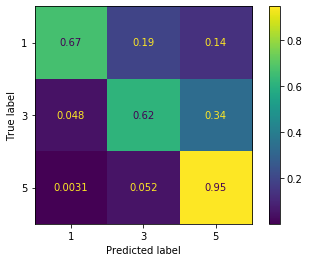

In [106]:
predictions = logreg.predict(X_test)
score = logreg.score(X_test, y_test)
print("multinominal naive bayes accuracy: {:.4f}".format(score))
plot_confusion_matrix(logreg, X_test, y_test, normalize = "true")

In [150]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [151]:
logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
logreg.fit(X_resampled, y_resampled)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

logistic regression with undersampling accuracy: 0.7893


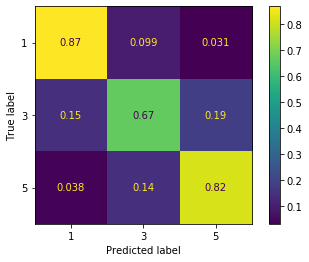

In [152]:
predictions = logreg.predict(X_test)
score = logreg.score(X_test, y_test)
print("logistic regression with undersampling accuracy: {:.4f}".format(score))
plot_confusion_matrix(logreg, X_test, y_test, normalize = "true")

# SVM Linear Kernel

In [41]:
from sklearn.svm import SVC

In general, SVM is O(n^3). Therefore, it is use feature selection... Going to use filter method 'SelectKBest'.

In [42]:
KBest = SelectKBest(chi2, k = 500)
KBest.fit(X_train, y_train)
X_train_best = KBest.transform(X_train)
X_test_best = KBest.transform(X_test)

svm grid search too expensive...

In [43]:
svc = SVC(kernel = 'linear', C = 1)
svc.fit(X_train_best, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

multinominal naive bayes accuracy: 0.8331


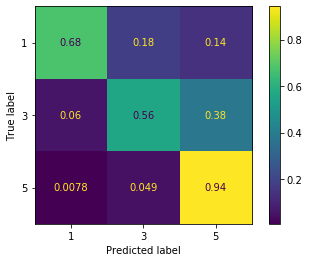

In [44]:
score = svc.score(X_test_best, y_test)
print("multinominal naive bayes accuracy: {:.4f}".format(score))
plot_confusion_matrix(svc, X_test_best, y_test, normalize = "true")

# Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

with feature selection...

In [51]:
rfc_KBest = RandomForestClassifier()
cross_val_score(rfc_KBest, X_best, y)

array([0.78393302, 0.79640185, 0.79747061, 0.79636558, 0.80616426])

without feature selection...

In [52]:
rfc = RandomForestClassifier()
cross_val_score(rfc, X, y)

array([0.75525472, 0.75757036, 0.75863912, 0.7548548 , 0.75734901])

In [53]:
rfc_KBest = RandomForestClassifier()
rfc_KBest.fit(X_train_best, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

random forest classifier accuracy: 0.7976


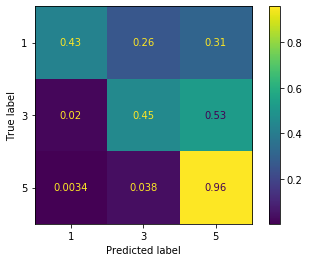

In [54]:
score = rfc_KBest.score(X_test_best, y_test)
print("random forest classifier accuracy: {:.4f}".format(score))
plot_confusion_matrix(rfc_KBest, X_test_best, y_test, normalize = "true")

# Adaboost Classifier

In [55]:
from sklearn.ensemble import AdaBoostClassifier

In [57]:
ada = AdaBoostClassifier()
cross_val_score(ada, X, y)

array([0.78001425, 0.78892056, 0.79301746, 0.78300374, 0.78834848])

In [58]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

adaboost accuracy: 0.7866


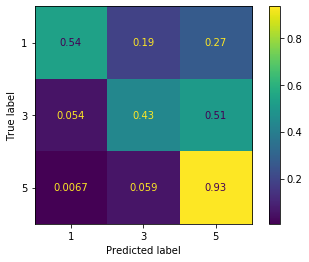

In [59]:
predictions = ada.predict(X_test)
score = ada.score(X_test, y_test)
print("adaboost accuracy: {:.4f}".format(score))
plot_confusion_matrix(ada, X_test, y_test, normalize = "true")

In [60]:
ada = AdaBoostClassifier()
ada.fit(X_train_best, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

adaboost accuracy: 0.7879


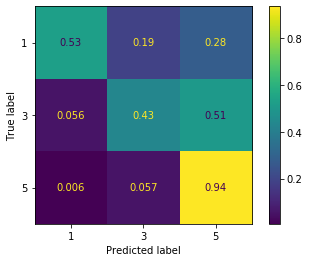

In [61]:
score = ada.score(X_test_best, y_test)
print("adaboost accuracy: {:.4f}".format(score))
plot_confusion_matrix(ada, X_test_best, y_test, normalize = "true")

Logistic Regression seems to be the best individual classifier. Lets trying tinkering around with some Logistic Regression parameters before we trying stacking the learners.

# Logistic Regression 2

Lets train the mnb classifier using all the data and these hyperparameters...

In [63]:
for ngrams in range(1, 4):
    
    X = train_data.review
    y = train_data.rating

    vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (1, ngrams))
    vectorizer.fit(X)
    X = vectorizer.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
    
    logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
    logreg.fit(X_train, y_train)
    score = logreg.score(X_test, y_test)
    
    print("ngrams = {}, logistic regression score is {}".format(ngrams, score))

ngrams = 1, logistic regression score is 0.8462771642322765
ngrams = 2, logistic regression score is 0.8537584609903812
ngrams = 3, logistic regression score is 0.8491271820448878


lets train the logistic regression model with ```ngram_range = (1, 2)```...

In [178]:
X = train_data.review
y = train_data.rating

other_features = ['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']
features = train_data[other_features]

vectorizer = CountVectorizer(ngram_range = (1, 2))
vectorizer.fit(X)
X = vectorizer.transform(X)

# stack the other features
from scipy import sparse
X = sparse.hstack((X, np.array(features)))

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [180]:
logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [181]:
score = logreg.score(X_test, y_test)
print(score)

0.8799429996437478


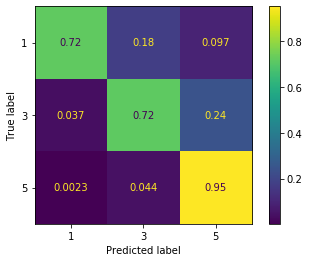

In [182]:
plot_confusion_matrix(logreg, X_test, y_test, normalize = "true")

In [17]:
clfs = {
    "mnb": MultinomialNB(alpha = 1),
    "lr": LogisticRegression(max_iter=1000000, C = 0.1, penalty = 'l2'),
    "svm":  SVC(kernel = 'linear', C = 1.0)
}

train_data['total_votes'] = train_data['vote_funny'] + train_data['vote_cool'] + train_data['vote_useful']

X = train_data[['review', 'total_votes', 'vote_funny', 'vote_cool', 'vote_useful']]
y = train_data['rating']

other_features = ['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

d2v_50_train_split, d2v_50_test_split = train_test_split(d2v_50_train, train_size = 0.8, random_state = 0)
d2v_100_train_split, d2v_100_test_split = train_test_split(d2v_100_train, train_size = 0.8, random_state = 0)
d2v_200_train_split, d2v_200_test_split = train_test_split(d2v_200_train, train_size = 0.8, random_state = 0)

KBest = SelectKBest(chi2, k = 500)

In [18]:
import warnings
warnings.filterwarnings('ignore')

for ngrams in range(1, 3):

    vectorizer = CountVectorizer(ngram_range = (1, ngrams))
    vectorizer.fit(X_train.review)
    X_train_review = vectorizer.transform(X_train.review)
    X_test_review = vectorizer.transform(X_test.review)

    print("ngrams = {}".format(ngrams))
    
    for classifier in list(clfs.keys()):
        
#         if classifier == "svm":
#             X_train_best = KBest.fit_transform(X_train_review, y_train)
#             X_test_best = KBest.transform(X_test_review)
        
        clf = clfs[classifier]
        print(classifier)
        
        clf.fit(X_train_review, np.matrix(y_train).reshape(-1, 1))
        score = clf.score(X_test_review, np.matrix(y_test).reshape(-1, 1))
        print("CountVectoriser score {}".format(score))
        
        if classifier != "mnb":
            clf.fit(d2v_50_train_split, np.matrix(y_train).reshape(-1, 1))
            score = clf.score(d2v_50_test_split, np.matrix(y_test).reshape(-1, 1))
            print("d2v 50 score {}".format(score))
            clf.fit(d2v_100_train_split, np.matrix(y_train).reshape(-1, 1))
            score = clf.score(d2v_100_test_split, np.matrix(y_test).reshape(-1, 1))
            print("d2v 100 score {}".format(score))
            clf.fit(d2v_200_train_split, np.matrix(y_train).reshape(-1, 1))
            score = clf.score(d2v_200_test_split, np.matrix(y_test).reshape(-1, 1))
            print("d2v 200 score {}".format(score))
        

ngrams = 1
mnb
CountVectoriser score 0.8485928037050231
lr
CountVectoriser score 0.8653366583541147
d2v 50 score 0.8129675810473815
d2v 100 score 0.8224082650516565
d2v 200 score 0.8320270751692198
svm
CountVectoriser score 0.8420021375133595
d2v 50 score 0.8113644460277877


KeyboardInterrupt: 

# Stacking

In [142]:
for i in range(1, 3):
    
    print(i)
    
    train_data['total_votes'] = train_data['vote_funny'] + train_data['vote_cool'] + train_data['vote_useful']

    X = train_data[['review', 'total_votes', 'vote_funny', 'vote_cool', 'vote_useful']]
    y = train_data['rating']

    other_features = ['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

    X_train_clfs, X_train_meta, y_train_clfs, y_train_meta = train_test_split(X_train, y_train, train_size = 0.8, random_state = 0)

    vectorizer = CountVectorizer(ngram_range = (1, i))
    vectorizer.fit(X_train_clfs.review)

    X_train_clfs_review = vectorizer.transform(X_train_clfs.review)
    X_train_clfs_sparse = sparse.hstack((X_train_clfs_review, np.array(X_train_clfs[other_features])))

    X_train_meta_review = vectorizer.transform(X_train_meta.review)
    X_train_meta_sparse = sparse.hstack((X_train_meta_review, np.array(X_train_meta[other_features])))

    X_test_review = vectorizer.transform(X_test.review)
    X_test_sparse = sparse.hstack((X_test_review, np.array(X_test[other_features])))

    classifiers = {
        "mnb": MultinomialNB(alpha = 1),
    #     "rfc": RandomForestClassifier(),
        "lr": LogisticRegression(max_iter=1000000, C = 0.1, penalty = 'l2'),
        "svm":  SVC(kernel = 'linear', C = 1.0),
    #     "adaboost": AdaBoostClassifier()
    }

    clfs = []

    for classifier in list(classifiers.keys()):

        print("training {}".format(classifier))

        clf = classifiers[classifier]

        clf.fit(X_train_clfs_sparse, y_train_clfs)

        clfs.append(clf)

    clf_predictions = []

    for clf in clfs:
        predictions = clf.predict(X_train_meta_sparse)
        clf_predictions.append(predictions)

    clf_predictions = np.stack(clf_predictions).transpose()

    meta_clf = AdaBoostClassifier()
    meta_clf.fit(clf_predictions, y_train_meta)

    predictions_list = []

    for clf in clfs:

        predictions = clf.predict(X_test_sparse)
        predictions_list.append(predictions)
        score = clf.score(X_test_sparse, np.array(y_test))
        print("{} accuracy is {}".format(clf.__class__, score))

    meta_predictions = np.stack(predictions_list).transpose()

    meta_score = meta_clf.score(meta_predictions, np.array(y_test))

    print("meta classifier score is {}".format(meta_score))

1
training mnb
training lr
training svm
<class 'sklearn.naive_bayes.MultinomialNB'> accuracy is 0.8477021731385821
<class 'sklearn.linear_model._logistic.LogisticRegression'> accuracy is 0.8583897399358746
<class 'sklearn.svm._classes.SVC'> accuracy is 0.834698966868543
meta classifier score is 0.8624866405415034
2
training mnb
training lr
training svm
<class 'sklearn.naive_bayes.MultinomialNB'> accuracy is 0.7500890630566441
<class 'sklearn.linear_model._logistic.LogisticRegression'> accuracy is 0.8726398289989312
<class 'sklearn.svm._classes.SVC'> accuracy is 0.8574991093694335
meta classifier score is 0.8733523334520841


# Predictions

In [154]:
X = train_data.review
y = train_data.rating

other_features = ['total_votes', 'vote_funny', 'vote_cool', 'vote_useful']
features = train_data[other_features]

In [155]:
vectorizer = CountVectorizer(ngram_range = (1, 2))
vectorizer.fit(X)
X = vectorizer.transform(X)

# stack the other features
from scipy import sparse
X = sparse.hstack((X, np.array(features)))

In [156]:
# KBest = SelectKBest(chi2, k = 1000)
# KBest.fit(X, y)
# X_train_best = KBest.transform(X)

In [158]:
logreg = LogisticRegression(C = 0.1, max_iter = 1000000, penalty = 'l2')
logreg.fit(X, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [159]:
X_test = test_data.review
X_test = vectorizer.transform(X_test)

test_data['total_votes'] = test_data['vote_funny'] + test_data['vote_cool'] + test_data['vote_useful']
features = test_data[other_features]
X_test = sparse.hstack((X_test, np.array(features)))

predictions = logreg.predict(X_test)

In [160]:
predictions

array([5, 5, 1, ..., 3, 5, 5], dtype=int64)

In [161]:
predictionsdf = pd.DataFrame(list(enumerate(predictions, start = 1)))
predictionsdf = predictionsdf.rename(columns = {0: 'instance_id', 1: 'rating'})
predictionsdf.to_csv("logistic_regression.csv", index = False)
predictionsdf

,instance_id,rating
0,1,5
1,2,5
2,3,1
3,4,3
4,5,5
...,...,...
7013,7014,5
7014,7015,5
7015,7016,3
7016,7017,5
